In [1]:
!pip install pandas scikit-learn matplotlib seaborn tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# --- VAE Model Definition ---
input_dim = X_train.shape[1]
latent_dim = 2  # You can try 2, 4, or 8

print(df)

       Methane (ppb)    Moisture  Temperature  Humidity       R2611E  \
0         2100.70715  20582.5430        26.67     55.95  48084.59906   
1         2099.28955  20957.3300        26.85     56.70  48148.62996   
2         2097.97055  21332.3525        26.97     57.45  48052.63847   
3         2096.84830  21747.0935        27.10     58.15  47872.18378   
4         2095.69300  22167.4180        27.25     58.85  47593.10141   
...              ...         ...          ...       ...          ...   
14181     2096.37915  21730.3185        28.38     56.45  62956.99743   
14182     2096.20445  21873.8575        28.43     56.55  62726.47196   
14183     2096.11315  22022.0560        28.45     56.65  62224.43611   
14184     2095.98925  22154.9580        28.51     56.70  62129.79514   
14185     2095.87460  22277.3470        28.52     56.80  61778.07977   

             R2600        R2602       R2611C         RMQ4  
0      24372.15496  31174.78061  34230.24621  54108.59287  
1      23995.55

In [26]:
# --- Encoder ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')


In [32]:
# --- VAE as a Model Subclass ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction))

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(inputs, reconstruction))
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

vae = VAE(encoder, decoder, input_dim)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


In [33]:
# --- Training ---
history = vae.fit(X_train, epochs=100, batch_size=64, validation_data=(X_test, None), verbose=2)

Epoch 1/100
178/178 - 3s - 17ms/step - kl_loss: 0.1625 - loss: 0.9745 - reconstruction_loss: 0.8119 - val_loss: 0.9722
Epoch 2/100
178/178 - 1s - 6ms/step - kl_loss: 0.1229 - loss: 0.7671 - reconstruction_loss: 0.6443 - val_loss: 0.9691
Epoch 3/100
178/178 - 1s - 3ms/step - kl_loss: 0.1719 - loss: 1.0128 - reconstruction_loss: 0.8409 - val_loss: 0.9748
Epoch 4/100
178/178 - 1s - 3ms/step - kl_loss: 0.1468 - loss: 0.9847 - reconstruction_loss: 0.8379 - val_loss: 0.9465
Epoch 5/100
178/178 - 1s - 3ms/step - kl_loss: 0.1915 - loss: 1.0499 - reconstruction_loss: 0.8584 - val_loss: 0.9615
Epoch 6/100
178/178 - 1s - 4ms/step - kl_loss: 0.2040 - loss: 1.2397 - reconstruction_loss: 1.0357 - val_loss: 0.9716
Epoch 7/100
178/178 - 1s - 4ms/step - kl_loss: 0.1809 - loss: 1.0286 - reconstruction_loss: 0.8477 - val_loss: 0.9639
Epoch 8/100
178/178 - 1s - 7ms/step - kl_loss: 0.1541 - loss: 0.8667 - reconstruction_loss: 0.7126 - val_loss: 0.9631
Epoch 9/100
178/178 - 1s - 5ms/step - kl_loss: 0.1522 -

In [34]:
# --- Generate Synthetic Data ---
n_samples = X_test.shape[0]
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702   8216.909090  12916.562275

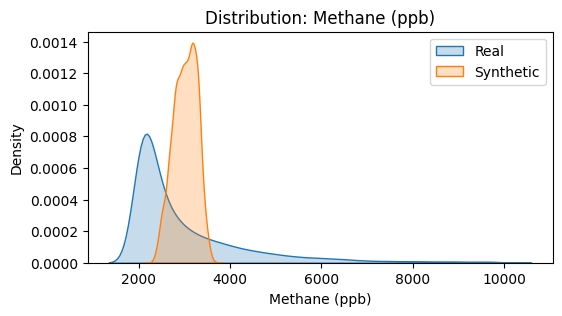

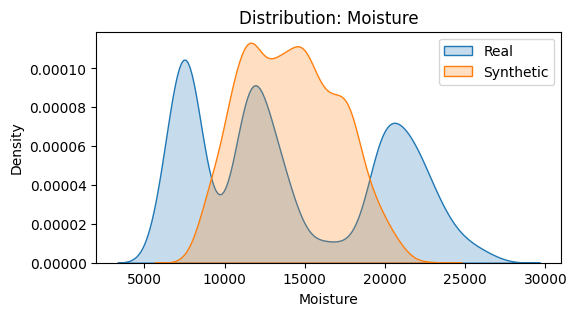

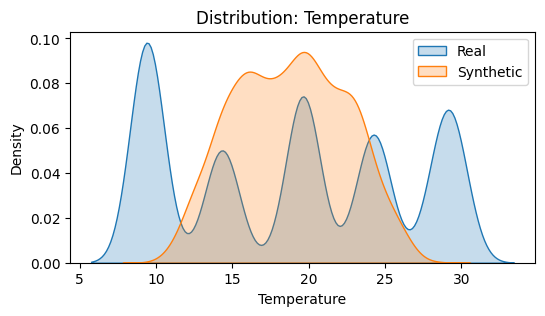

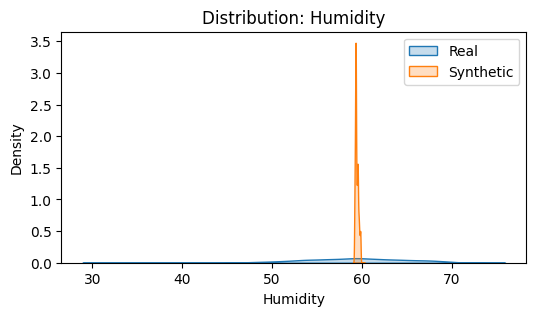

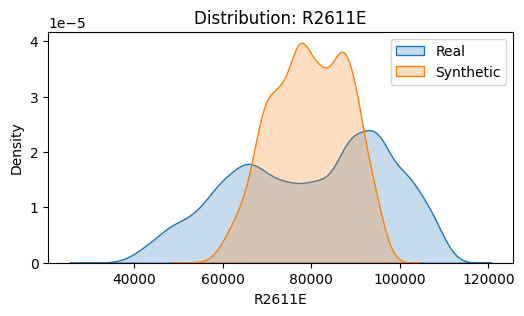

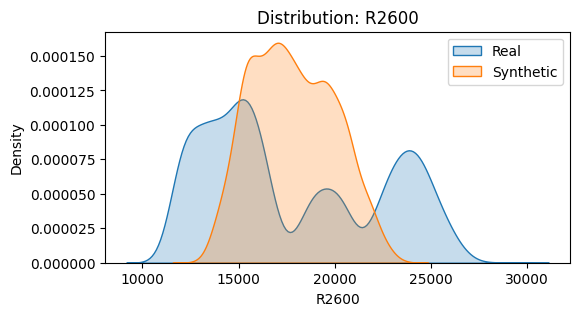

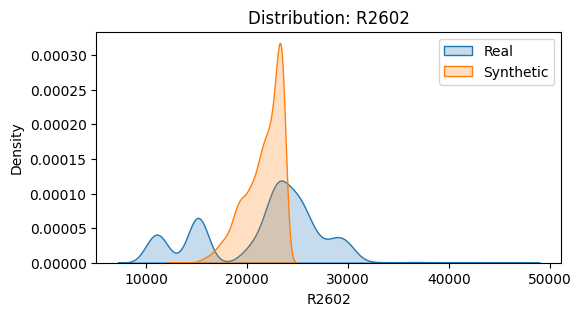

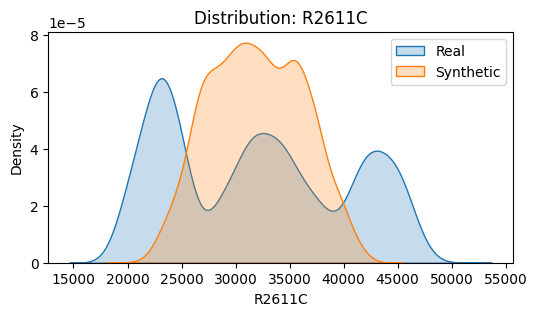

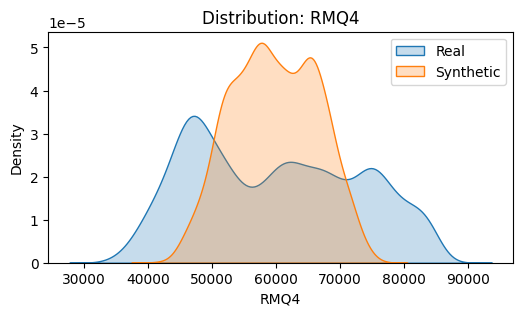

Synthetic data saved as synthetic_data_vae.csv


In [35]:
# --- Compare Real vs. Synthetic ---
print('Real Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())

for col in df.columns:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[col], label='Real', fill=True)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True)
    plt.title(f'Distribution: {col}')
    plt.legend()
    plt.show()

df_synth.to_csv('/content/synthetic_data_vae.csv', index=False)
print('Synthetic data saved as synthetic_data_vae.csv')

In [2]:
# --- latent_dim = 8 ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# --- VAE Model Definition ---
input_dim = X_train.shape[1]
latent_dim = 8

print(df)

       Methane (ppb)    Moisture  Temperature  Humidity       R2611E  \
0         2100.70715  20582.5430        26.67     55.95  48084.59906   
1         2099.28955  20957.3300        26.85     56.70  48148.62996   
2         2097.97055  21332.3525        26.97     57.45  48052.63847   
3         2096.84830  21747.0935        27.10     58.15  47872.18378   
4         2095.69300  22167.4180        27.25     58.85  47593.10141   
...              ...         ...          ...       ...          ...   
14181     2096.37915  21730.3185        28.38     56.45  62956.99743   
14182     2096.20445  21873.8575        28.43     56.55  62726.47196   
14183     2096.11315  22022.0560        28.45     56.65  62224.43611   
14184     2095.98925  22154.9580        28.51     56.70  62129.79514   
14185     2095.87460  22277.3470        28.52     56.80  61778.07977   

             R2600        R2602       R2611C         RMQ4  
0      24372.15496  31174.78061  34230.24621  54108.59287  
1      23995.55

In [3]:
# --- Encoder ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- VAE as a Model Subclass ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction))

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(inputs, reconstruction))
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

vae = VAE(encoder, decoder, input_dim)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


# --- Training ---
history = vae.fit(X_train, epochs=100, batch_size=64, validation_data=(X_test, None), verbose=2)

Epoch 1/100
178/178 - 3s - 19ms/step - kl_loss: 0.0058 - loss: 1.0361 - reconstruction_loss: 1.0303 - val_loss: 0.9974
Epoch 2/100
178/178 - 1s - 5ms/step - kl_loss: 0.0127 - loss: 0.9607 - reconstruction_loss: 0.9479 - val_loss: 0.9869
Epoch 3/100
178/178 - 1s - 3ms/step - kl_loss: 0.0287 - loss: 1.0946 - reconstruction_loss: 1.0659 - val_loss: 0.9786
Epoch 4/100
178/178 - 1s - 4ms/step - kl_loss: 0.0680 - loss: 1.2186 - reconstruction_loss: 1.1507 - val_loss: 0.9842
Epoch 5/100
178/178 - 1s - 3ms/step - kl_loss: 0.1038 - loss: 0.9784 - reconstruction_loss: 0.8746 - val_loss: 0.9753
Epoch 6/100
178/178 - 1s - 4ms/step - kl_loss: 0.0911 - loss: 0.6927 - reconstruction_loss: 0.6016 - val_loss: 0.9758
Epoch 7/100
178/178 - 1s - 3ms/step - kl_loss: 0.0896 - loss: 0.9393 - reconstruction_loss: 0.8497 - val_loss: 0.9654
Epoch 8/100
178/178 - 1s - 3ms/step - kl_loss: 0.1537 - loss: 0.8248 - reconstruction_loss: 0.6711 - val_loss: 0.9481
Epoch 9/100
178/178 - 1s - 3ms/step - kl_loss: 0.1391 -

In [4]:
# --- Generate Synthetic Data ---
n_samples = X_test.shape[0]
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702   8216.909090  12916.562275

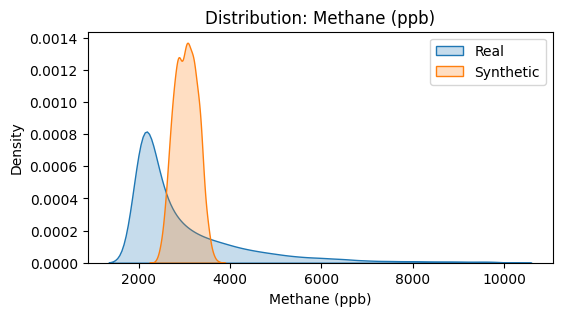

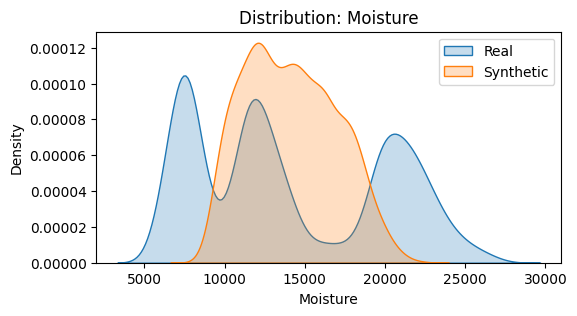

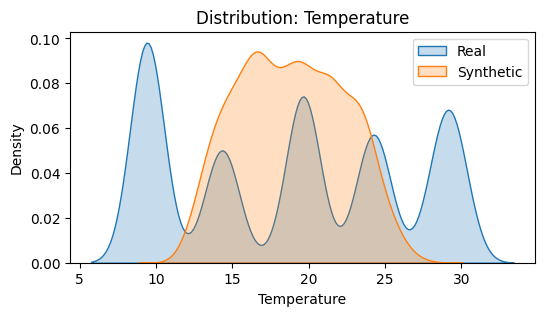

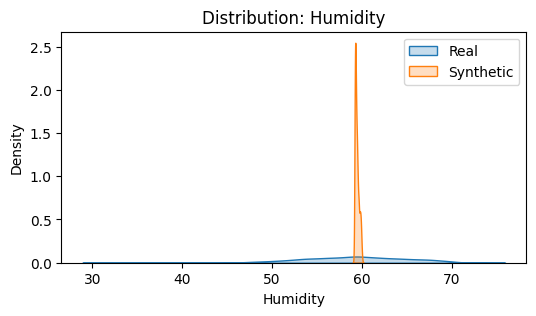

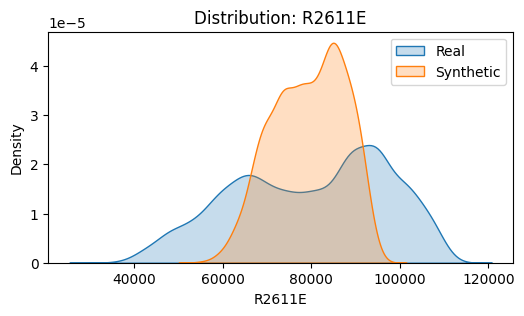

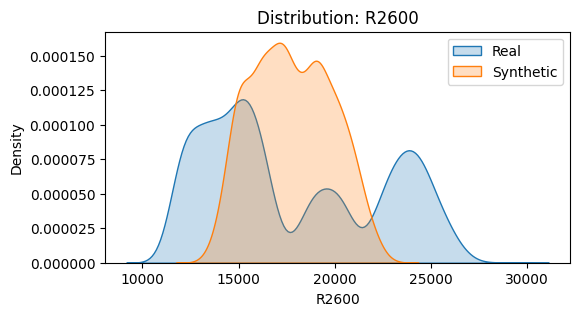

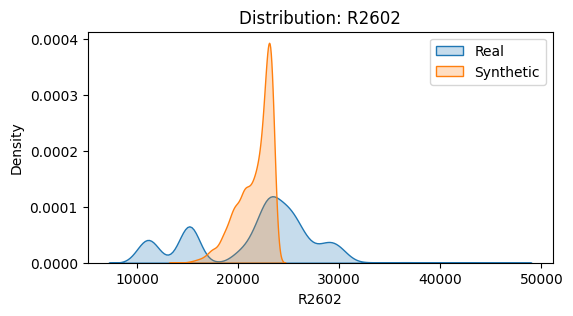

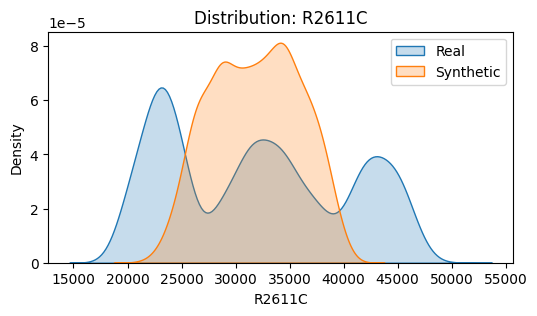

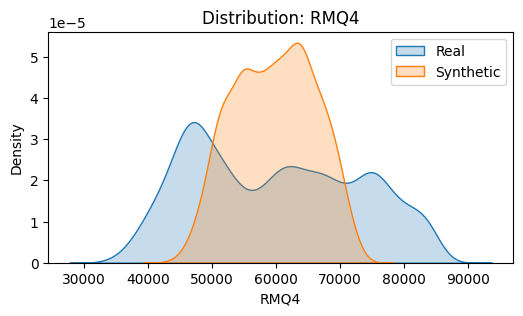

Synthetic data saved as synthetic_data_vae.csv


In [5]:
# --- Compare Real vs. Synthetic ---
print('Real Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())

for col in df.columns:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[col], label='Real', fill=True)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True)
    plt.title(f'Distribution: {col}')
    plt.legend()
    plt.show()

df_synth.to_csv('/content/synthetic_data_vae_latent_8.csv', index=False)
print('Synthetic data saved as synthetic_data_vae.csv')

In [1]:
# --- latent_dim = 8 ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# --- VAE Model Definition ---
input_dim = X_train.shape[1]
latent_dim = 8

print(df)

       Methane (ppb)    Moisture  Temperature  Humidity       R2611E  \
0         2100.70715  20582.5430        26.67     55.95  48084.59906   
1         2099.28955  20957.3300        26.85     56.70  48148.62996   
2         2097.97055  21332.3525        26.97     57.45  48052.63847   
3         2096.84830  21747.0935        27.10     58.15  47872.18378   
4         2095.69300  22167.4180        27.25     58.85  47593.10141   
...              ...         ...          ...       ...          ...   
14181     2096.37915  21730.3185        28.38     56.45  62956.99743   
14182     2096.20445  21873.8575        28.43     56.55  62726.47196   
14183     2096.11315  22022.0560        28.45     56.65  62224.43611   
14184     2095.98925  22154.9580        28.51     56.70  62129.79514   
14185     2095.87460  22277.3470        28.52     56.80  61778.07977   

             R2600        R2602       R2611C         RMQ4  
0      24372.15496  31174.78061  34230.24621  54108.59287  
1      23995.55

In [2]:
# with latent_dim=8 and all the enhancements (deeper network, early stopping, lower learning rate, and option for MAE loss):

# --- Encoder (Deeper) ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder (Deeper) ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- VAE as a Model Subclass ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss (MSE or MAE)
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(inputs, reconstruction))
        # For MAE, use: reconstruction_loss = tf.reduce_mean(keras.losses.mae(inputs, reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

vae = VAE(encoder, decoder, input_dim)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

# --- Early Stopping Callback ---
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
history = vae.fit(
    X_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, None),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/200
178/178 - 5s - 27ms/step - loss: 1.0217 - val_loss: 0.9838
Epoch 2/200
178/178 - 1s - 5ms/step - loss: 1.0080 - val_loss: 0.9856
Epoch 3/200
178/178 - 1s - 7ms/step - loss: 1.0071 - val_loss: 0.9857
Epoch 4/200
178/178 - 1s - 3ms/step - loss: 1.0069 - val_loss: 0.9813
Epoch 5/200
178/178 - 1s - 4ms/step - loss: 1.0067 - val_loss: 0.9836
Epoch 6/200
178/178 - 1s - 4ms/step - loss: 1.0060 - val_loss: 0.9826
Epoch 7/200
178/178 - 1s - 4ms/step - loss: 1.0063 - val_loss: 0.9833
Epoch 8/200
178/178 - 1s - 3ms/step - loss: 1.0043 - val_loss: 0.9802
Epoch 9/200
178/178 - 1s - 4ms/step - loss: 1.0045 - val_loss: 0.9806
Epoch 10/200
178/178 - 1s - 4ms/step - loss: 1.0031 - val_loss: 0.9823
Epoch 11/200
178/178 - 2s - 9ms/step - loss: 1.0019 - val_loss: 0.9776
Epoch 12/200
178/178 - 1s - 7ms/step - loss: 0.9980 - val_loss: 0.9837
Epoch 13/200
178/178 - 1s - 7ms/step - loss: 0.9941 - val_loss: 0.9897
Epoch 14/200
178/178 - 1s - 5ms/step - loss: 0.9892 - val_loss: 0.9725
Epoch 15/200
1

In [3]:
# --- Generate Synthetic Data ---
n_samples = X_test.shape[0]
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702   8216.909090  12916.562275

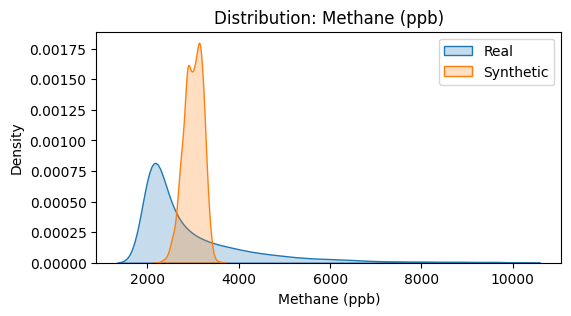

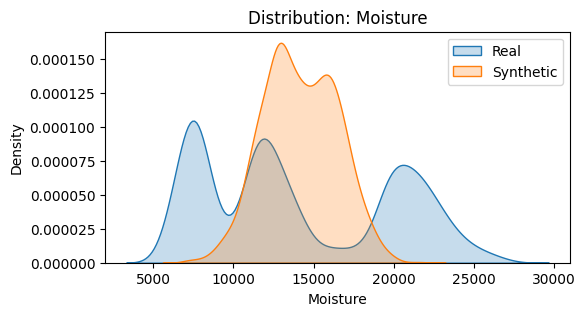

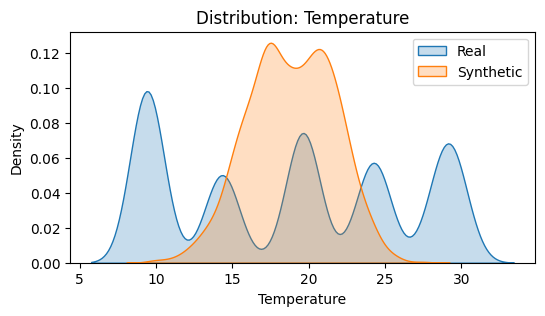

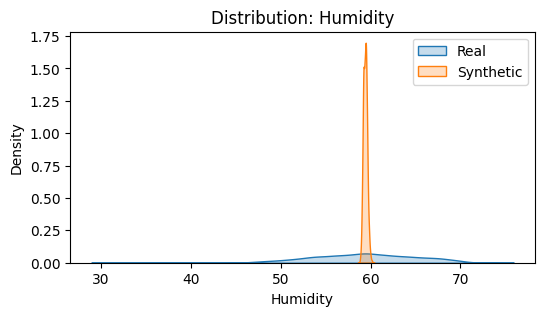

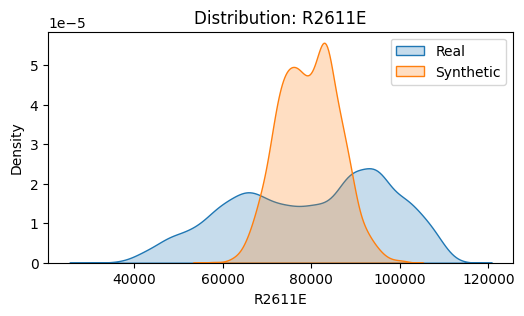

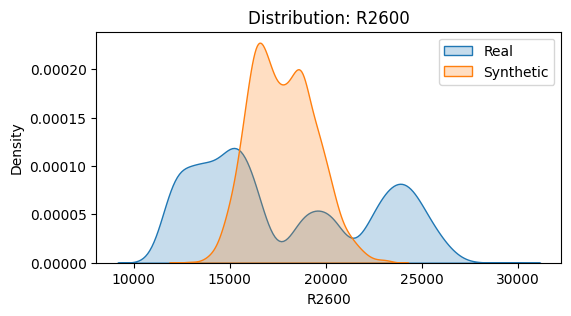

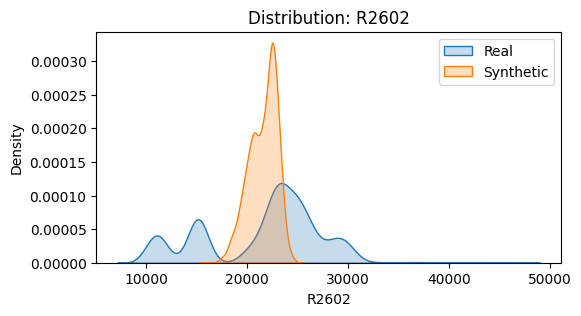

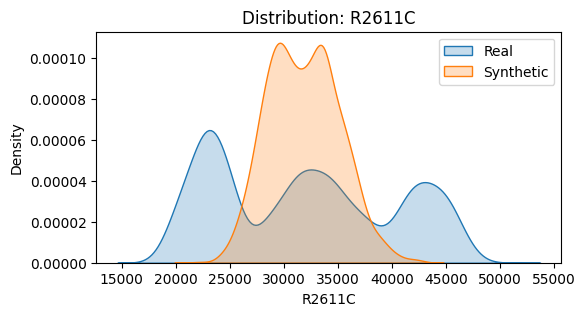

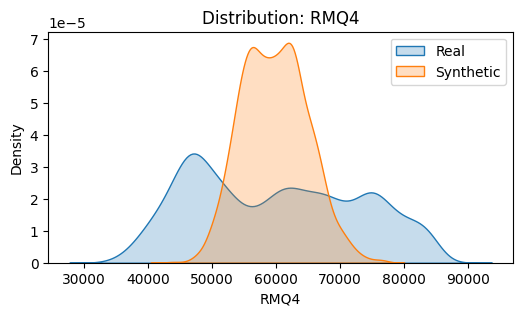

Synthetic data saved as synthetic_data_vae_improved.csv


In [4]:
# --- 10. Compare Real vs. Synthetic ---
print('Real Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())

for col in df.columns:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[col], label='Real', fill=True)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True)
    plt.title(f'Distribution: {col}')
    plt.legend()
    plt.show()

df_synth.to_csv('/content/synthetic_data_vae_improved.csv', index=False)
print('Synthetic data saved as synthetic_data_vae_improved.csv')